In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import seaborn as sns
sns.set_theme(font_scale=1.5);

In [2]:
h        = np.linspace(0, 999, 1000);
Earray   = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)
binWidth = np.hstack([np.diff(Earray), np.diff(Earray)[-1]]);

from matplotlib.colors import LogNorm


killedParticleCounter = 0;
killedParticleEnergy  = 0;
with open("../build/output.log", 'r') as f:

    A = f.readlines()[1445:-1]
        
    for line in A:
        if 'Track' in line and 'energy' in line:
            #print(float(line[23:-1].split(' ')[0]))
            killedParticleCounter += 1
            killedParticleEnergy  += float(line[23:-1].split(' ')[0]);
            
print("Number of killed particles: %.0f\nKilled particle total energy: %.1f keV" % 
      (killedParticleCounter, 1e3*killedParticleEnergy))


def KrauseIonization(altitude):
    '''
    altitude in km
    returns ionization in keV
    '''
    r = (-0.03 * altitude + 39.78)/1e3;
    r[altitude > 240] = (-0.03 * 240 + 39.78)/1e3
    r[altitude < 45] = (-0.03 * 45 + 39.78)/1e3

    return r;

def readAndAverage(filename):
    #data = pd.read_csv("../data/" + filename, names=['E']);
    data = pd.read_csv("/home/grant/Documents/Research/G4EPP-git/G4EPP/data/" + filename, names=['E'])

    lineNo   = 1000;

    nThreads = int(len(data)/lineNo);
    
    ionResults = np.zeros([1, lineNo]);
    ionVar     = np.zeros([1, lineNo]);
    for i in range(0, nThreads):
        ionResults += data.E[lineNo*i:lineNo*(i+1)]
    
    for i in range(0, nThreads):
        ionVar += (data.E[lineNo*i:lineNo*(i+1)] - ionResults[0,:])**2;
    
    return ionResults.flatten(), np.sqrt(1/(nThreads-1) * ionVar.flatten());

def readAndAverage2D(filename):
    
    Earray = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)

    data = pd.read_csv("../data/" + filename, names=Earray);
    
    lineNo   = 1000;
    
    nThreads = int(len(data)/lineNo);
    
    data.fillna(data.mean(), inplace=True)

    results    = np.zeros([lineNo, 100]);
    resultsVar = np.zeros([lineNo, 100]);
    for i in range(0, nThreads):
        results += data.values[lineNo*i:lineNo*(i+1), :];
        
    for i in range(0, nThreads):
        resultsVar += (data.values[lineNo*i:lineNo*(i+1), :]/binWidth - results/binWidth)**2;

    return results/binWidth, np.sqrt(1/(nThreads - 1) * resultsVar);
    
def plot_spectra(ionResults, EResults, ionVar, Evar):

    plt.figure(figsize=(14,8)); plt.subplot(1,2,1); 
    plt.grid(True, which='both')
    #plt.plot(ionResults/KrauseIonization(h), h, label='$\mu$');
    #plt.fill_betweenx(h, (ionResults-ionVar)/KrauseIonization(h), 
    #                     (ionResults+ionVar)/KrauseIonization(h), 
    #                  alpha=0.5, label='$\pm \sigma$')
    
    plt.plot(ionResults, h, label='$\mu$');
    plt.fill_betweenx(h, (ionResults-ionVar), 
                         (ionResults+ionVar), 
                      alpha=0.5, label='$\pm \sigma$')
    
    plt.xscale('log');
    plt.xlabel('Deposited Energy [keV/km]');
    plt.ylabel('Altitude [km]');
    #plt.ylim([0, 240]);
    plt.legend()

    X,Y = np.meshgrid(Earray, h);

    #ionVar[h < 120] *= 2;
    
    plt.subplot(1,2,2); plt.grid(True, which='both')
    #plt.contourf(X, Y, EResults, norm=LogNorm());
    try:
        plt.pcolormesh(X, Y, EResults, norm=LogNorm());
        plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ keV$^{-1}$]');

    except:
        #EResults[0,0] = 1;
        plt.pcolormesh(X, Y, EResults, norm=LogNorm());
        plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ keV$^{-1}$]');

    plt.xscale('log');
    plt.xlabel('Energy [keV]');
    plt.ylabel('Altitude [km]');
    #plt.ylim([0, 240]);

def plot_altitude_spectra(EResults, Evar):
    plt.figure(figsize=(10,6)); plt.grid(True, which='both');

    startingAlt = 10;
    stepSize    = 5;

    for j in range(0, 4):

        h1 = startingAlt + j*stepSize;
        h2 = startingAlt + stepSize + j*stepSize;

        ave    = np.zeros([1, len(Earray)])
        aveVar = np.zeros([1, len(Earray)])
        for i in range(h1, h2):
            ave += EResults[i, :]
            aveVar += np.sqrt(Evar[i,:])

        plt.step(Earray, savgol_filter(ave[0,:], 1, 0), label='%.0f - %.0f km' % (h1,h2));
        
    startingAlt = 500;
    stepSize    = 5;

    for j in range(0, 1):

        h1 = startingAlt + j*stepSize;
        h2 = startingAlt + stepSize + j*stepSize;

        ave    = np.zeros([1, len(Earray)])
        aveVar = np.zeros([1, len(Earray)])
        for i in range(h1, h2):
            ave    += EResults[i, :]
            aveVar += np.sqrt(Evar[i,:])

        plt.step(Earray, savgol_filter(ave[0,:], 1, 0), label='%.0f - %.0f km' % (h1,h2));
        
    plt.xscale('log');
    plt.yscale('log');
    plt.legend();
    plt.xlabel('Energy [keV]');
    plt.ylabel('Relative Intensity');
    plt.title('Average Spectra with Altitude');
    
    
shift = 115;
def powerLawFit(x, a, b):
    return x*a + b;

def plot_altitude_energy_spectra(EResults, Evar):
    plt.figure(figsize=(8,10)); plt.grid(True, which='both');

    windowSize = 10;
    
    for j in [1e0, 1e1, 1e2, 1e3]:
        
        E1 = j;
        E2 = j*windowSize
        
        inds = (Earray > E1) & (Earray < E2);

        #ave    = np.mean(EResults[:,inds], axis=1);
        ave    = np.trapz(EResults[:,inds], x=Earray[inds])
        #aveVar = np.mean(np.sqrt(Evar[:,inds]), axis=1);
        
        plt.step(savgol_filter(ave, 1, 0), h, label='%.0f - %.0f keV' % (E1,E2));
        
        popt,pcov = curve_fit(powerLawFit, h[shift:-1], ave[shift:-1]);
        print("Slope: %.3f flux/100 km" % (100*popt[0]))
        
        plt.plot(powerLawFit(h[shift:-1], *popt), h[shift:-1], '--');
        

    plt.xscale('log');
    plt.legend();
    plt.xlabel('Photon Flux [cm$^{-2}$ s$^{-1}$]');
    plt.ylabel('Altitude [km]');
    plt.title('Average Spectra with Altitude');
    plt.ylim([0,1000]);
    #plt.xlim([0, 500]);

Number of killed particles: 4
Killed particle total energy: 521.2 keV


In [3]:
post = '10000'

fn1 = "electron_dep_test.csv"
fn2 = "electron_ene_test.csv"
fn3 = "photon_dep_test.csv"
fn4 = "photon_ene_test.csv"

fn1 = "electron_dep_spectra" + post + "keV_iso_1e4_latest.csv"
fn2 = "electron_ene_spectra" + post + "keV_iso_1e4_latest.csv"
fn3 = "photon_dep_spectra" + post + "keV_iso_1e4_latest.csv"
fn4 = "photon_ene_spectra" + post + "keV_iso_1e4_latest.csv"


ionResults, ionVar       = readAndAverage(fn1);
EResults, Evar           = readAndAverage2D(fn2);
ph_ionResults, ph_ionVar = readAndAverage(fn3);
ph_EResults, ph_Evar     = readAndAverage2D(fn4);


plot_spectra(ionResults, EResults, ionVar, Evar);
plt.suptitle('Electrons');
plt.subplot(1,2,1);
plt.plot(np.trapz(EResults, x=Earray, axis=1), h)


#plt.ylim(0, 200);
#plt.xlim(1e1, 1e5)

plt.subplot(1,2,2);
#plt.ylim(50, 100);
plt.xlim(1e0, 1e3);


Nparts = 10000;
E0     = 100;
Ttot = E0 * Nparts - 1e3*killedParticleEnergy;

print("Total input energy: %.5e keV\n" % Ttot)

print("Electrons from spectra: %.3e " % np.trapz(np.trapz(EResults, x=Earray, axis=1), x=h, axis=0))
print("Electrons from ionization: %.3e" % np.trapz(ionResults, x=h, axis=0))

print("Photons from spectra: %.3e " % (np.trapz(np.trapz(ph_EResults, x=Earray, axis=1), x=h, axis=0)))
print("Photons from ionization: %.3e" % (np.trapz(ph_ionResults, x=h, axis=0)))


print("Both from spectra: (%.4e keV) %.2f%%" % ((np.sum(np.trapz(EResults, x=Earray, axis=1)) + 
                                          np.sum(np.trapz(ph_EResults, x=Earray, axis=1))), 
                                      (np.sum(np.trapz(EResults, x=Earray, axis=1)) + 
                                          np.sum(np.trapz(ph_EResults, x=Earray, axis=1)))/Ttot/5 * 100))


print("Both from ionization: (%.4e keV) %.5f%% --> (%.4f eV) %.5f%% energy unaccounted for!\n" % 
                                                  ((np.sum(ionResults) + np.sum(ph_ionResults)), 
                                                   (np.sum(ionResults) + np.sum(ph_ionResults))/Ttot * 100,
                                                   1e3*(Ttot - (np.sum(ionResults) + np.sum(ph_ionResults))),
                                                  (1 - (np.sum(ionResults) + np.sum(ph_ionResults))/Ttot) * 100))

plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plt.suptitle('Photons');
plt.subplot(1,2,1);
plt.plot(np.trapz(ph_EResults, x=Earray), h)

plot_spectra(savgol_filter(ionResults + ph_ionResults, 1, 0), 
             (EResults+ph_EResults), 
             savgol_filter(ionVar+ph_ionVar, 1,0), 
             Evar+ph_Evar);

plt.suptitle('Electrons + Photons');

plt.subplot(1,2,1);
#plt.ylim(0, 200);
#plt.xlim(1e-2, 1e5);
     
plt.subplot(1,2,2);
#plt.ylim(0, 200);
#plt.xlim(8e-1, 3e4);
plt.yscale('log')
    
plot_altitude_spectra(ph_EResults, ph_Evar);
plot_altitude_energy_spectra(ph_EResults, ph_Evar);
#plt.xscale('linear');

#plt.ylim(0, 80);

plt.figure(figsize=(12,6)); plt.grid(True, which='both');
plt.step(Earray, EResults[999,:]);
plt.yscale('log');
plt.xscale('log');
plt.xlabel('Energy [keV]');
plt.ylabel('FLux [cm$^{-2}$ s$^{-1}$ keV$^{-1}$]');

tmp = np.trapz(EResults[999,:], x=Earray);

print("\nTotal flux at top of sim: %.3e cm^-2 sec^-1 (%.3f %% of input particles)" % (tmp, tmp/Nparts * 100))
print("Total energy >200 km altitude: %.3e keV (%.2f %% of total energy)"
      % (ionResults[999], ionResults[999]/Ttot * 100))

FileNotFoundError: [Errno 2] No such file or directory: '/home/grant/Documents/Research/G4EPP-git/G4EPP/data/electron_dep_spectra10000keV_iso_1e4_latest.csv'

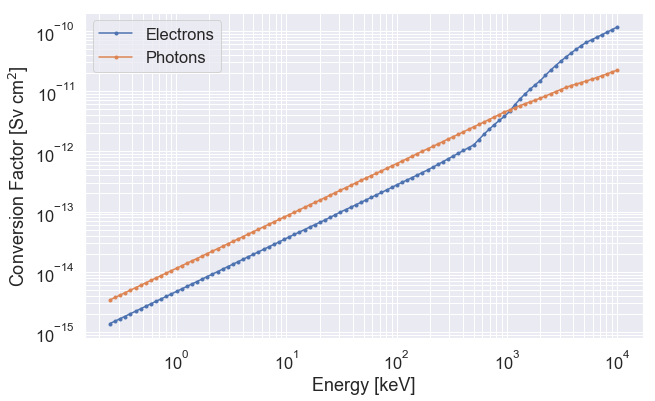

In [5]:
def extrapolateLowEnd(data, Elow):
    
    fit  = np.polyfit(np.log10(data[0:8,0]), np.log10(data[0:8,1]) , 1);

    line = np.poly1d(fit);
    
    # Reassemble data array 
    A = np.concatenate([Elow, data[:,0]]);
    B = np.concatenate([10**line(np.log10(Elow)), data[:,1]]);
        
    return np.vstack([A, B]).T;
    

# (electron energy [eV], conversion factor [Sv cm^2])
el_conv = np.array([[1.0217e+4, 3.6869e-14],
                    [1.6588e+4, 5.6234e-14],
                    [2.2729e+4, 7.3564e-14],
                    [3.1526e+4, 1.0000e-13],
                    [4.3197e+4, 1.3082e-13],
                    [5.8478e+4, 1.7113e-13],
                    [8.1106e+4, 2.2821e-13],
                    [1.0210e+5, 2.8184e-13],
                    [2.0368e+5, 5.2079e-13],
                    [5.1162e+5, 1.3082e-12],
                    [1.0221e+6, 4.2170e-12],
                    [2.0425e+6, 1.5252e-11],
                    [5.1374e+6, 6.3096e-11],
                    [1.0125e+7, 1.1659e-10],
                    [2.0447e+7, 2.2821e-10],
                    [5.1286e+7, 3.2860e-10],
                    [1.0340e+8, 3.4145e-10]]);

ph_conv = np.array([[9.9309e+3, 8.3937e-14],
                    [1.5706e+4, 1.2555e-13],
                    [2.7780e+4, 2.0628e-13],
                    [4.9686e+4, 3.4351e-13],
                    [8.8869e+4, 5.6439e-13],
                    [1.6073e+5, 9.5257e-13],
                    [2.9072e+5, 1.5862e-12],
                    [4.7548e+5, 2.4371e-12],
                    [9.4043e+5, 4.4583e-12],
                    [1.4225e+6, 6.0694e-12],
                    [1.9027e+6, 7.3223e-12],
                    [2.7830e+6, 9.8361e-12],
                    [3.7223e+6, 1.2190e-11],
                    [4.4521e+6, 1.3388e-11],
                    [5.3849e+6, 1.4903e-11],
                    [7.2839e+6, 1.7979e-11],
                    [9.4211e+6, 2.1402e-11],
                    [1.7824e+7, 3.3314e-11],
                    [2.7885e+7, 4.3553e-11],
                    [3.6068e+7, 5.1152e-11],
                    [4.6662e+7, 5.5415e-11],
                    [9.1344e+7, 7.0475e-11]])


el_conv = extrapolateLowEnd(el_conv, np.logspace(np.log10(Earray[0]*1e3), np.log10(el_conv[0,0]), 10));
ph_conv = extrapolateLowEnd(ph_conv, np.logspace(np.log10(Earray[0]*1e3), np.log10(ph_conv[0,0]), 10));


el_resamp = np.interp(Earray, el_conv[:,0]/1000, el_conv[:,1]);
ph_resamp = np.interp(Earray, ph_conv[:,0]/1000, ph_conv[:,1]);

#print(Earray, el_resamp)
plt.figure(figsize=(10,6)); plt.grid(True, which='both');
#plt.plot(el_conv[:,0]*1e-3, el_conv[:,1], '.--');
#plt.plot(ph_conv[:,0]*1e-3, ph_conv[:,1], '.--')
plt.plot(Earray, el_resamp, '.-', label='Electrons');
plt.plot(Earray, ph_resamp, '.-', label='Photons');
plt.legend();
plt.xscale('log');
plt.yscale('log');
plt.xlabel('Energy [keV]');
plt.ylabel('Conversion Factor [Sv cm$^2$]');

In [21]:

#np.savetxt("electron_human_dose_conversion.csv", np.vstack([Earray, el_resamp]).T, delimiter=',')
#np.savetxt("photon_human_dose_conversion.csv",   np.vstack([Earray, ph_resamp]).T, delimiter=',')


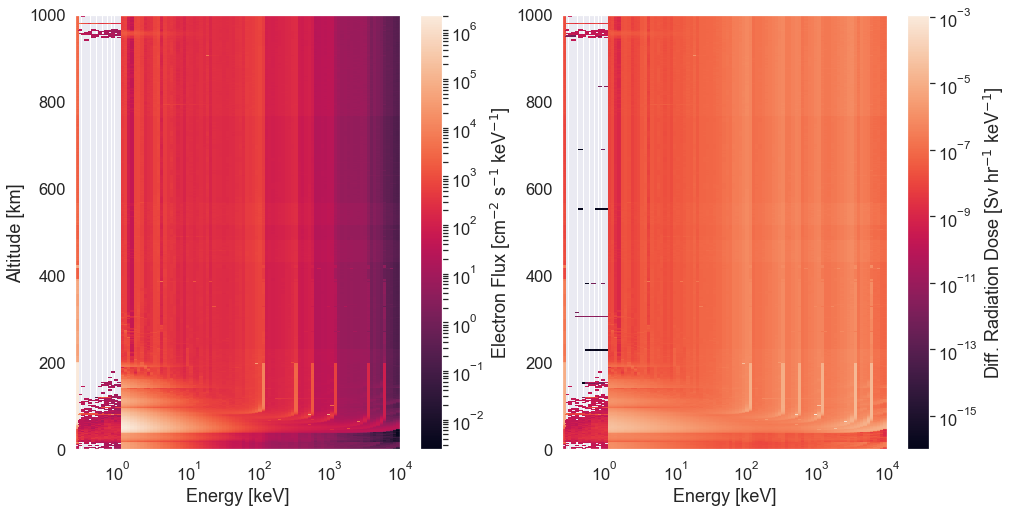

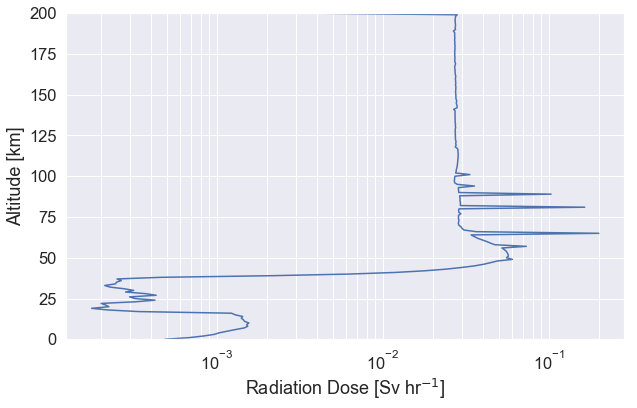

In [6]:
'''
def convertToRadDose(el_spectra, ph_spectra):
    
    dosage_alt_array = np.zeros([1000]);
    
    for i in range(0, len(el_spectra)):
        dosage_alt_array[i] = np.sum(el_spectra[i,:] * el_resamp) + np.sum(ph_spectra[i,:] * ph_resamp);
        
    i = 90;
    print(el_spectra[i,:])
    print(el_resamp)
        
    print(el_spectra[i,:] * el_resamp)
        
    return dosage_alt_array;
''';      
    
def convertToDiffRadDose(el_spectra, ph_spectra):
    
    dosage_alt_array = np.zeros([1000, 100]);
    
    for i in range(0, 1000):
        dosage_alt_array[i,:] = el_spectra[i,:] * el_resamp + ph_spectra[i,:] * ph_resamp;

    return dosage_alt_array;
    
#d = convertToRadDose(EResults, ph_EResults/1e3);

'''
plt.figure(figsize=(10,8)); plt.grid(True, which='both')
plt.plot(savgol_filter(d, 11, 1)*3600, h);
plt.xlabel('Radiation Dose [Sv hr$^{-1}$]');
plt.ylabel('Altitude [km]');
plt.xscale('log');
#plt.xlim([5e-3*3600*1e-6, 5e-1*3600*1e-6]);
#plt.ylim([1e0, 1e3]);
#plt.yscale('log');
''';

X, Y = np.meshgrid(Earray, h);
import matplotlib.colors as cl

plt.figure(figsize=(16,8)); 

plt.subplot(1,2,1); plt.grid(True, which='both');

plt.pcolormesh(X, Y, EResults, norm=LogNorm())
plt.colorbar(label='Electron Flux [cm$^{-2}$ s$^{-1}$ keV$^{-1}$]');

plt.xscale('log');
#plt.xlim(1e-1, 3e4);
plt.xlabel('Energy [keV]')
plt.ylabel('Altitude [km]');

#plt.ylim(0, 200);


plt.subplot(1,2,2); plt.grid(True, which='both');

A = convertToDiffRadDose(EResults, ph_EResults/1e3)*3600

plt.pcolormesh(X, Y, A, norm=LogNorm());
#plt.plot(np.sum(convertToRadDose(EResults, ph_EResults/1e3)*3600, axis=1), h, 'b');

#plt.ylim(0, 200);

plt.colorbar(label='Diff. Radiation Dose [Sv hr$^{-1}$ keV$^{-1}$]');

plt.xlabel('Energy [keV]');
#plt.ylabel('Altitude [km]');
plt.xscale('log');
#plt.yscale('log');

#plt.xlim([1e-1, 3e4]);


plt.figure(figsize=(10,6)); plt.grid(True, which='both')
plt.plot(np.trapz(A, x=Earray), h, 'b');
plt.xscale('log');
plt.ylabel('Altitude [km]');
plt.xlabel('Radiation Dose [Sv hr$^{-1}$]');
plt.ylim(0, 200);
#plt.xlim(1e-5, 1e-3);

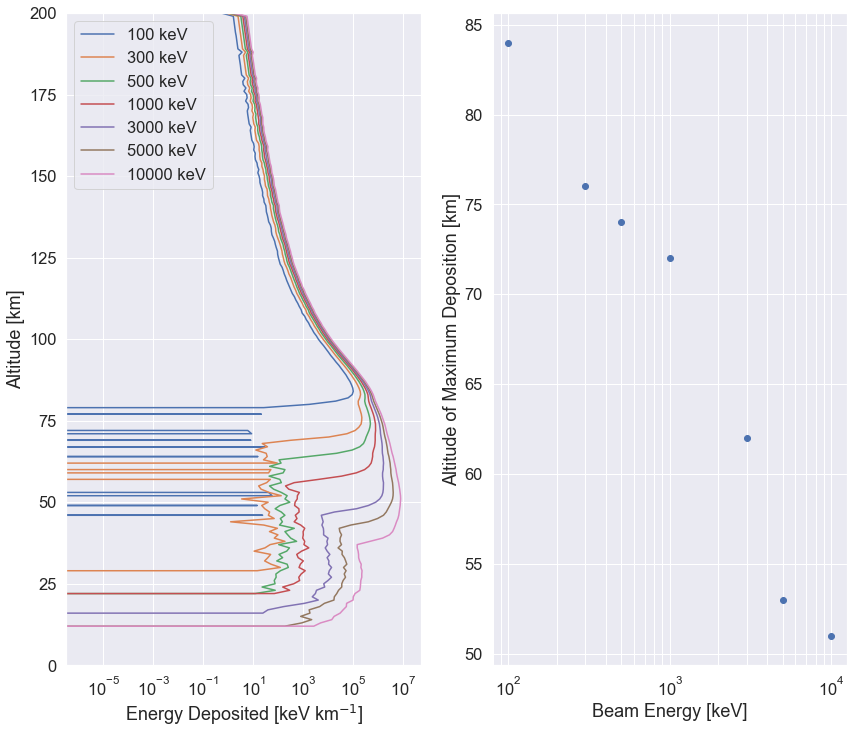

In [7]:
from scipy.io import loadmat

maxI = 1e5;

plt.figure(figsize=(14,12)); plt.subplot(1,2,1); plt.grid(True, which='both');
for post in [100, 300, 500, 1000, 3000, 5000, 10000]:
    plt.subplot(1,2,1);
    fn1 = "electron_dep_spectra" + str(post) + "keV_iso_1e4_latest.csv"
    fn3 = "photon_dep_spectra" + str(post) + "keV_iso_1e4_latest.csv"

    ionResults, ionVar     = readAndAverage(fn1);
    ph_ionResults, ionVar  = readAndAverage(fn3);
    
    totalE = ionResults + ph_ionResults;
    normFactor = np.max(totalE[0:-2])/maxI;
    normFactor = 1;
    
    totalE /= normFactor;
    
    plt.plot(savgol_filter(totalE, 1, 0), h, label="%.0f keV" % post);
    
    plt.subplot(1,2,2);
    plt.plot(post, h[np.argmax(totalE[0:-2])], 'bo')

plt.subplot(1,2,1);
plt.xlabel('Energy Deposited [keV km$^{-1}$]');
plt.ylabel('Altitude [km]');
plt.xscale('log');
plt.legend();
plt.ylim(0, 200);

plt.subplot(1,2,2); plt.grid(True, which='both')
plt.xscale('log');
plt.xlabel('Beam Energy [keV]');
plt.ylabel('Altitude of Maximum Deposition [km]');
#plt.ylim(0, 100);

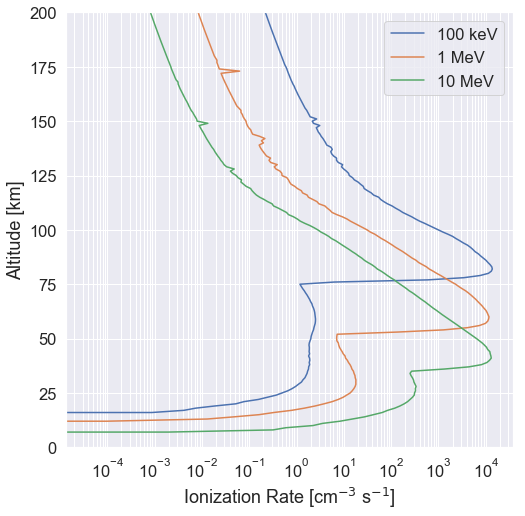

In [8]:
wei_data = loadmat("fig2_results.mat");

#print(wei_data['fig2d'][0][0])

plt.figure(figsize=(8,8)); plt.grid(True, which='both');
plt.plot(np.array(wei_data["fig2d"][0][0][2][0,:]), wei_data["fig2d"][0][0][0][0,:], label='100 keV');
plt.plot(np.array(wei_data["fig2d"][0][0][4][0,:]), wei_data["fig2d"][0][0][0][0,:], label='1 MeV');
plt.plot(np.array(wei_data["fig2d"][0][0][6][0,:]), wei_data["fig2d"][0][0][0][0,:], label='10 MeV');

plt.xscale('log');
plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]');
plt.ylabel('Altitude [km]');
plt.ylim(0, 200);
plt.legend();

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars


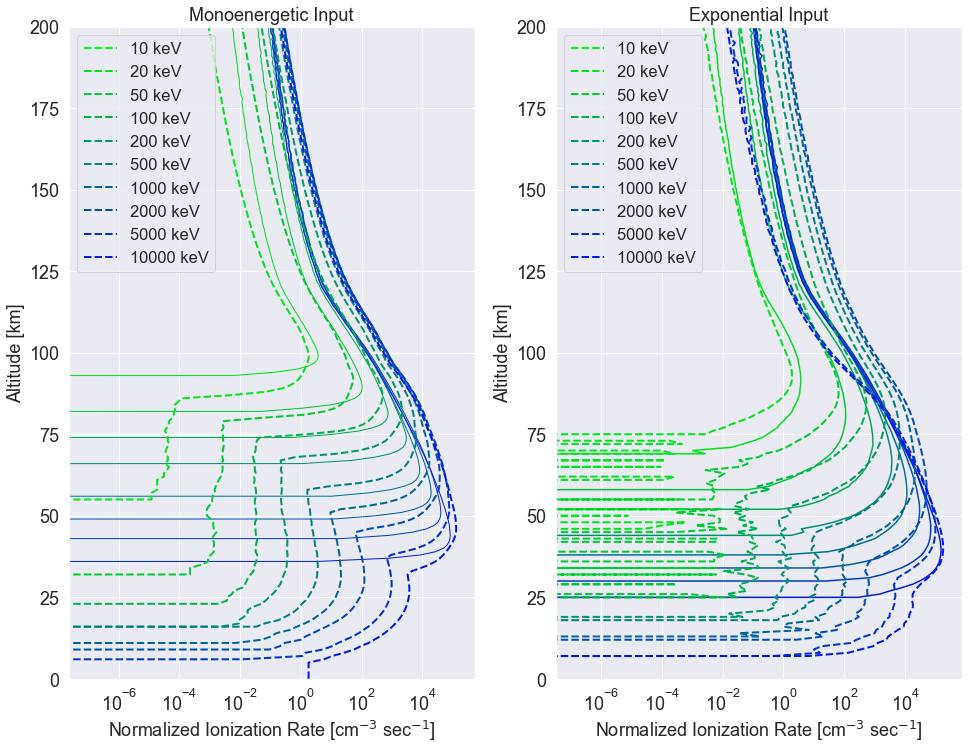

In [82]:
bob_data = loadmat("edepProfiles.mat")
# fields: edepNmono, edepNexp, energy, alt 

plt.figure(figsize=(16,12))
plt.subplot(1,2,1); plt.grid(True, which='both');
for i in range(0, 9):
    plt.semilogx(bob_data['edepNmono'][:,i] * (i*10)**5, bob_data['alt'],lineWidth=1,
                 color=[0, 1-i/9, i/9]);

plt.ylabel('Altitude [km]'); plt.xlabel('Normalized Ionization Rate [cm$^{-3}$ sec$^{-1}$]'); 
plt.ylim([20, 150]);
plt.title('Monoenergetic Input');
plt.ylim(0, 200);


plt.subplot(1,2,2); plt.grid(True, which='both');
for i in range(0, 9):
    plt.semilogx(bob_data['edepNexp'][:,i] * (i*10)**5, bob_data['alt'], 
                color=[0, 1-i/9, i/9]); 
    
plt.xlabel('Normalized Ionization Rate [cm$^{-3}$ sec$^{-1}$]'); plt.ylabel('Altitude [km]'); plt.ylim([20, 300]);
#plt.legend(bob_data['energy'][0]/1000);
plt.title('Exponential Input');
plt.ylim(0, 200);


filt = [9, 9, 9, 9, 9, 5, 7, 5, 3, 3]
filt = [1]*10


plt.subplot(1,2,1); 
#for post in [100, 300, 500, 1000, 3000, 5000, 10000]:
for i, post in enumerate([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]):
    
    maxI = 2.5e-5 * (i*10)**5;

    plt.subplot(1,2,1);
    #fn1 = "electron_dep_spectra" + str(post) + "keV_mono_1e4_sin45.csv"
    #fn3 = "photon_dep_spectra"   + str(post) + "keV_mono_1e4_sin45.csv"
    
    fn1 = "mono/electron_dep_spectra" + str(post) + "keV_mono_1e4_sin45_lowCeiling.csv"
    fn3 = "mono/photon_dep_spectra"   + str(post) + "keV_mono_1e4_sin45_lowCeiling.csv"


    ionResults, ionVar     = readAndAverage(fn1);
    ph_ionResults, ionVar  = readAndAverage(fn3);
    
    totalE = ionResults + ph_ionResults;
    normFactor = np.max(totalE[0:-2])/maxI;
    
    totalE /= normFactor;
    
    plt.plot(savgol_filter(totalE, 11, 0), h, '--', lineWidth=2,color=[0, 1-i/10, i/10], label='%.0f keV' % post);
    
    maxI = 3e-5 * (i*10) ** 5;
    
    
    plt.subplot(1,2,2);
    
    #fn1 = "electron_dep_spectra" + str(post) + "keV_exp_1e4_sin45.csv"
    #fn3 = "photon_dep_spectra"   + str(post) + "keV_exp_1e4_sin45.csv"
    
    fn1 = "exp/electron_dep_spectra" + str(post) + "keV_exp_1e4_sin45_lowCeiling.csv"
    fn3 = "exp/photon_dep_spectra"   + str(post) + "keV_exp_1e4_sin45_lowCeiling.csv"


    ionResults, ionVar     = readAndAverage(fn1);
    ph_ionResults, ionVar  = readAndAverage(fn3);
    
    totalE = ionResults + ph_ionResults;
    normFactor = np.max(totalE[0:-2])/maxI;
    
    totalE /= normFactor;
    
    plt.plot(savgol_filter(totalE, filt[i], 0), h, '--', lineWidth=2,color=[0, 1-i/10, i/10], label='%.0f keV' % post);
    

plt.subplot(1,2,1);
plt.legend();
#plt.xlim(1e-2, 2e5);
plt.xscale('log');
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()

#plt.yscale('log')
#plt.ylim(1e-1, 200)

plt.subplot(1,2,2);
plt.legend();
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.legend();
#plt.xlim(1e-2, 2e5);

#plt.yscale('log')
#plt.ylim(1e-1, 200);

In [56]:
'''
bob_data = loadmat("edepProfiles.mat")
# fields: edepNmono, edepNexp, energy, alt 

plt.figure(figsize=(16,12))
plt.subplot(1,2,1); 

for i in range(0, 9):
    plt.semilogx(bob_data['edepNmono'][:,i] * 2.5e-4, bob_data['alt'], 
                 label="%.0f keV" % (bob_data['energy'][0][i]/1000), lineWidth=1,
                 color=[i/9,(9-i)/9,i/9]);

plt.ylim([20, 150]);
#plt.title('Monoenergetic Input');

plt.ylabel('Altitude [km]'); plt.xlabel('Normalized Ionization Rate [cm$^{-3}$ sec$^{-1}$]'); 
plt.ylim(0, 200);


plt.subplot(1,2,2); plt.grid(True, which='both');
for i in range(0, 9):
    plt.semilogx(bob_data['edepNexp'][:,i] * (i*10)**5, bob_data['alt'], 
                label="%.0f keV" % (bob_data['energy'][0][i]/1000),
                color=[i/9,(9-i)/9,i/9]); 
    
plt.xlabel('Normalized Ionization Rate [cm$^{-3}$ sec$^{-1}$]'); plt.ylabel('Altitude [km]'); plt.ylim([20, 300]);
#plt.legend(bob_data['energy'][0]/1000);
#plt.title('Exponential Input');
plt.ylim(0, 200);


filt = [9, 9, 9, 9, 9, 5, 7, 5, 3]

plt.subplot(1,2,1); 
#for post in [100, 300, 500, 1000, 3000, 5000, 10000]:
for i, post in enumerate([10, 20, 50, 100, 200, 500, 1000, 2000, 5000]):
    
    #maxI = 2.5e-5 * (i*10)**5;
    maxI = 2.5e-5

    plt.subplot(1,2,1);
    #fn1 = "electron_dep_spectra" + str(post) + "keV_mono_1e4_sin45.csv"
    #fn3 = "photon_dep_spectra"   + str(post) + "keV_mono_1e4_sin45.csv"
    
    fn1 = "electron_dep_spectra" + str(post) + "keV_mono_1e4_sin45_lowCeiling.csv"
    fn3 = "photon_dep_spectra"   + str(post) + "keV_mono_1e4_sin45_lowCeiling.csv"


    ionResults, ionVar     = readAndAverage(fn1);
    ph_ionResults, ionVar  = readAndAverage(fn3);
    
    totalE = ionResults + ph_ionResults;
    normFactor = np.max(totalE[0:200])/maxI;
    
    totalE /= normFactor;
    
    plt.plot(savgol_filter(totalE, filt[i], 0), h, '-', lineWidth=2, 
             color=[i/9,(9-i)/9,i/9], label='%0.f keV' % post);
    


plt.subplot(1,2,1); plt.grid(True, which='both');
plt.legend();
#plt.xlim(1e-2, 2e5);
plt.xscale('log');
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim(5e-11, 5e-5)

plt.subplot(1,2,2);
plt.legend();
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
#plt.xlim(1e-2, 2e5);

''';

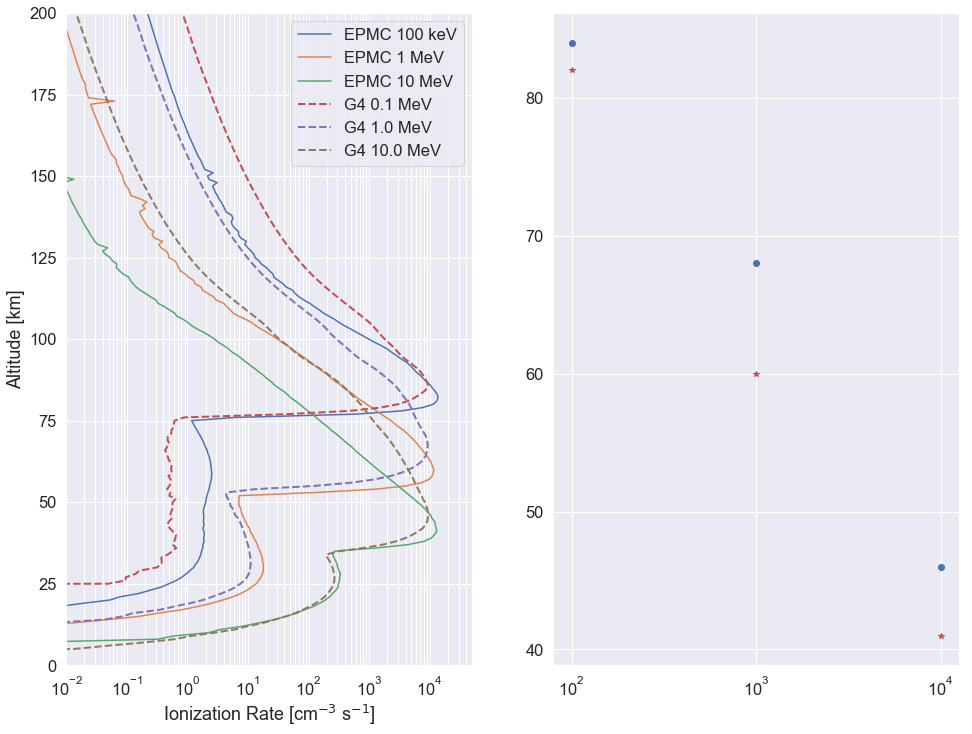

In [89]:
plt.figure(figsize=(16,12)); 

plt.subplot(1,2,1); plt.grid(True, which='both'); 
plt.plot(np.array(wei_data["fig2d"][0][0][2][0,:]), wei_data["fig2d"][0][0][0][0,:], label='EPMC 100 keV');
plt.plot(np.array(wei_data["fig2d"][0][0][4][0,:]), wei_data["fig2d"][0][0][0][0,:], label='EPMC 1 MeV');
plt.plot(np.array(wei_data["fig2d"][0][0][6][0,:]), wei_data["fig2d"][0][0][0][0,:], label='EPMC 10 MeV');

plt.subplot(1,2,2);
plt.plot(100, wei_data["fig2d"][0][0][0][0,np.argmax(np.array(wei_data["fig2d"][0][0][2][0,:]))], 'r*')
plt.plot(1000, wei_data["fig2d"][0][0][0][0,np.argmax(np.array(wei_data["fig2d"][0][0][4][0,:]))], 'r*')
plt.plot(10000, wei_data["fig2d"][0][0][0][0,np.argmax(np.array(wei_data["fig2d"][0][0][6][0,:]))], 'r*')

plt.xscale('log');

maxI = 1e4;
for post in [100, 1000, 10000]:
    plt.subplot(1,2,1);
    fn1 = "mono/electron_dep_spectra" + str(post) + "keV_mono_1e4_sin45_lowCeiling.csv"
    fn3 = "mono/photon_dep_spectra"    + str(post) + "keV_mono_1e4_sin45_lowCeiling.csv"

    ionResults, ionVar     = readAndAverage(fn1);
    ph_ionResults, ionVar  = readAndAverage(fn3);
    
    totalE = ionResults + ph_ionResults;
    normFactor = np.max(totalE[0:-2])/maxI;
    
    totalE /= normFactor;
    
    plt.plot(savgol_filter(totalE, 7, 1), h, '--', label="G4 %.1f MeV" % (post/1e3), lineWidth=2);

    plt.subplot(1,2,2);
    plt.plot(post, h[np.argmax(totalE[0:-2])], 'bo')

plt.subplot(1,2,1)
plt.xscale('log');
plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]');
plt.ylabel('Altitude [km]');
plt.ylim(0, 200);
plt.legend();
plt.xlim(1e-2, 5e4);

Slope: -0.105 flux/100 km
Slope: 0.000 flux/100 km
Slope: 0.000 flux/100 km
Slope: 0.000 flux/100 km

Total flux at top of sim: 3.996e+04 cm^-2 sec^-1 (399.556 % of input particles)
Total energy >200 km altitude: 2.259e+04 keV (1.13 % of total energy)


/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/matplotlib/contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


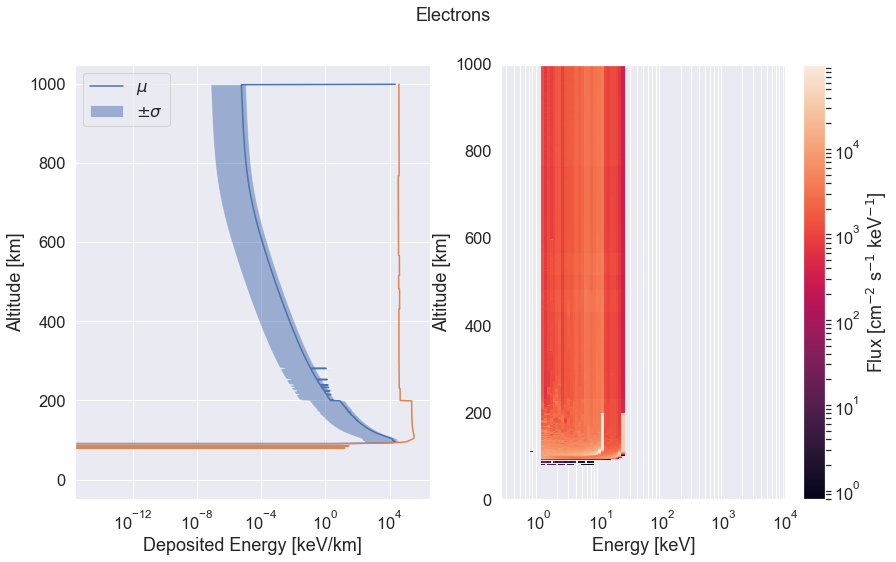

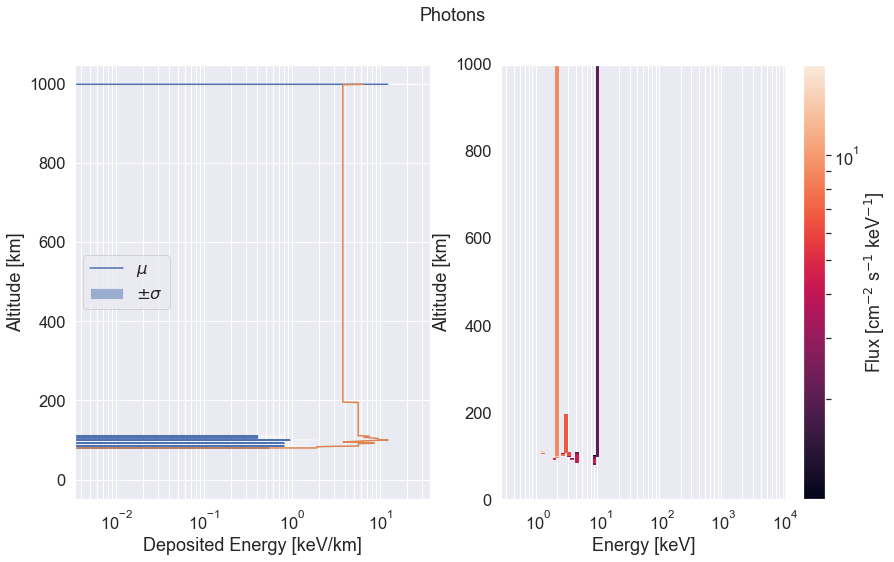

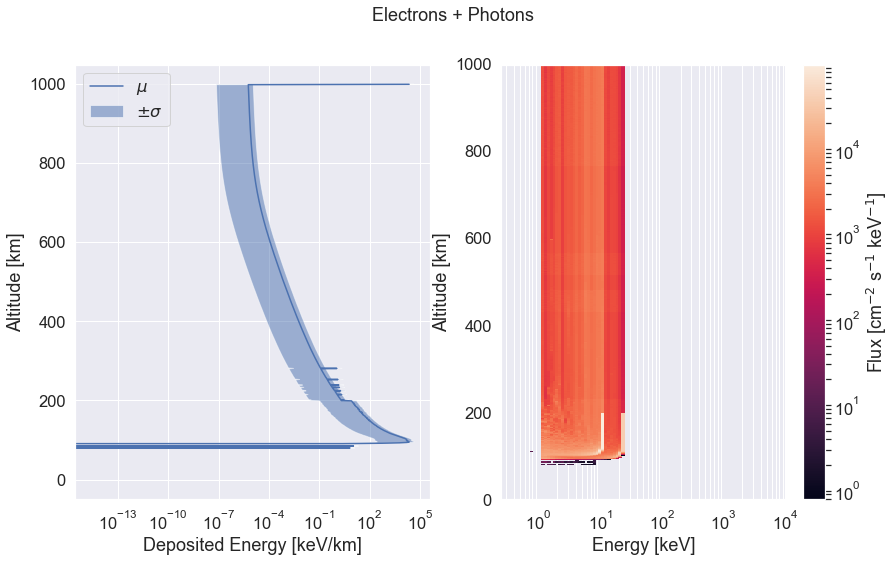

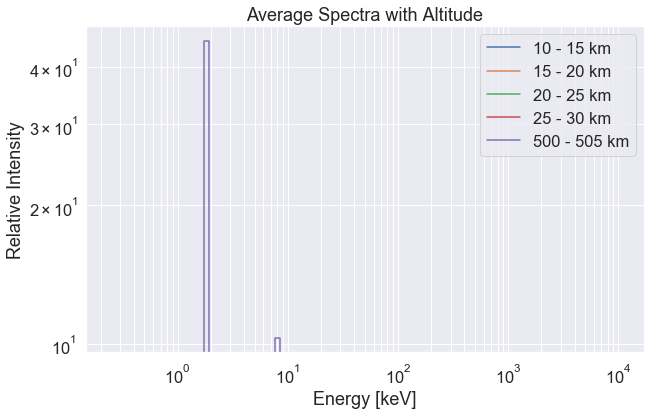

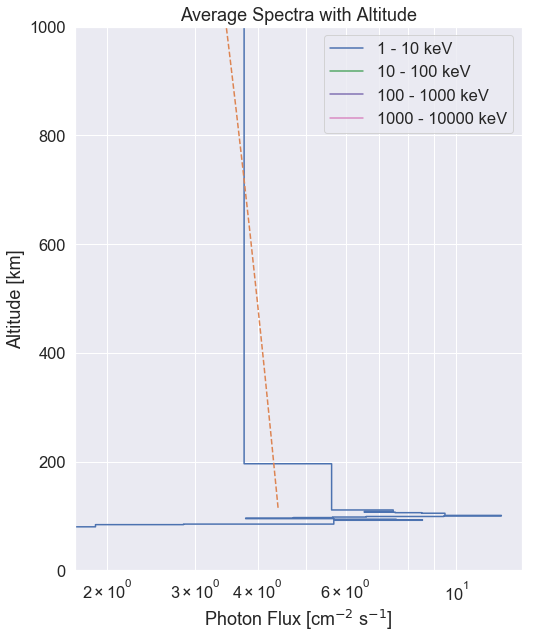

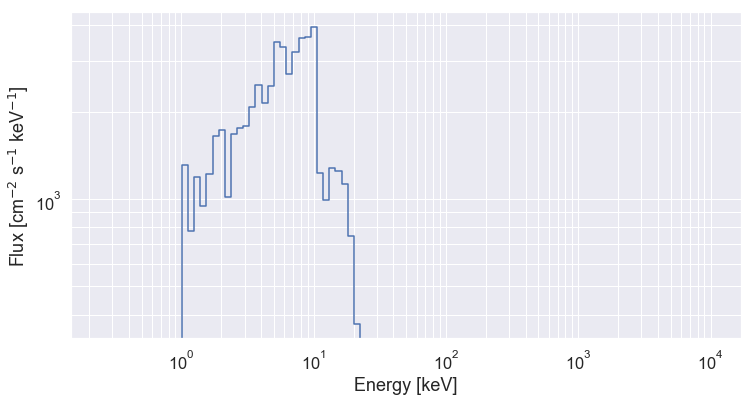

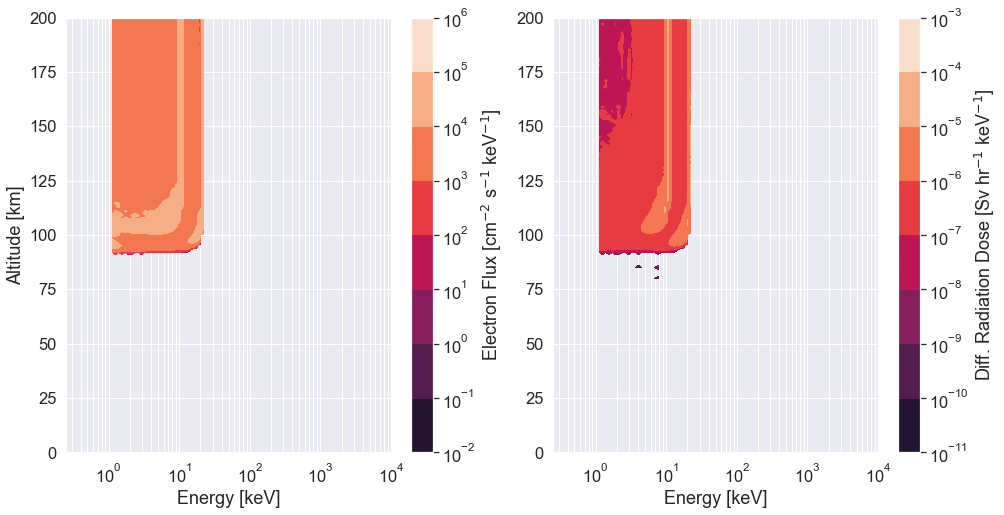

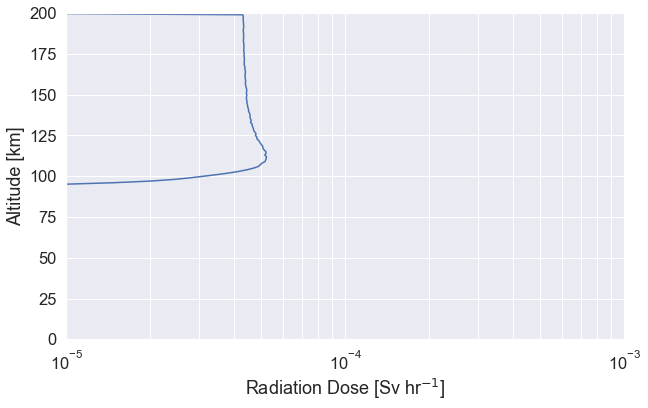

In [10]:
post = 20

fn1 = "electron_dep_spectra" + str(post) + "keV_mono_1e4_sin45.csv"
fn2 = "electron_ene_spectra" + str(post) + "keV_mono_1e4_sin45.csv"
fn3 = "photon_dep_spectra"   + str(post) + "keV_mono_1e4_sin45.csv"
fn4 = "photon_ene_spectra"   + str(post) + "keV_mono_1e4_sin45.csv"


ionResults, ionVar       = readAndAverage(fn1);
EResults, Evar           = readAndAverage2D(fn2);
ph_ionResults, ph_ionVar = readAndAverage(fn3);
ph_EResults, ph_Evar     = readAndAverage2D(fn4);


Ttot = post * 1e5;

plot_spectra(ionResults, EResults, ionVar, Evar);

plt.suptitle('Electrons', fontsize=18);
plt.subplot(1,2,1);
plt.plot(np.trapz(EResults, x=Earray, axis=1), h)



plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plt.suptitle('Photons', fontsize=18);
plt.subplot(1,2,1);
plt.plot(np.trapz(ph_EResults, x=Earray), h)

plot_spectra(savgol_filter(ionResults + ph_ionResults, 1, 0), 
             (EResults+ph_EResults), 
             savgol_filter(ionVar+ph_ionVar, 1,0), 
             Evar+ph_Evar);

plt.suptitle('Electrons + Photons', fontsize=18);

plot_altitude_spectra(ph_EResults, ph_Evar);
plot_altitude_energy_spectra(ph_EResults, ph_Evar);


plt.figure(figsize=(12,6)); plt.grid(True, which='both');
plt.step(Earray, EResults[999,:]);
plt.yscale('log');
plt.xscale('log');
plt.xlabel('Energy [keV]');
plt.ylabel('Flux [cm$^{-2}$ s$^{-1}$ keV$^{-1}$]');

tmp = np.trapz(EResults[999,:], x=Earray);

print("\nTotal flux at top of sim: %.3e cm^-2 sec^-1 (%.3f %% of input particles)" % (tmp, tmp/Nparts * 100))
print("Total energy >200 km altitude: %.3e keV (%.2f %% of total energy)"
      % (ionResults[999], ionResults[999]/Ttot * 100))



X, Y = np.meshgrid(Earray, h);

plt.figure(figsize=(16,8)); 

plt.subplot(1,2,1); plt.grid(True, which='both');

plt.contourf(X, Y, EResults, norm=LogNorm())
plt.colorbar(label='Electron Flux [cm$^{-2}$ s$^{-1}$ keV$^{-1}$]');

plt.xscale('log');
#plt.xlim(1e-1, 3e4);
plt.xlabel('Energy [keV]')
plt.ylabel('Altitude [km]');

#plt.xlim(4e-1, 2e1)
plt.ylim(0, 200);


plt.subplot(1,2,2); plt.grid(True, which='both');

A = convertToDiffRadDose(EResults, ph_EResults)*3600

plt.contourf(X, Y, A, norm=LogNorm());
#plt.plot(np.sum(convertToRadDose(EResults, ph_EResults/1e3)*3600, axis=1), h, 'b');

#plt.xlim(4e-1, 2e1)
plt.ylim(0, 200);

plt.colorbar(label='Diff. Radiation Dose [Sv hr$^{-1}$ keV$^{-1}$]');

plt.xlabel('Energy [keV]');
plt.xscale('log');


plt.figure(figsize=(10,6)); plt.grid(True, which='both')
plt.plot(np.trapz(A, x=Earray), h, 'b');
plt.xscale('log');
plt.ylabel('Altitude [km]');
plt.xlabel('Radiation Dose [Sv hr$^{-1}$]');
plt.ylim(0, 200);
#plt.xlim(1e-5, 1e-3);
plt.xlim(1e-5, 1e-3);